# Kickstarter Projects
https://www.kaggle.com/kemical/kickstarter-projects

## KickStarterとは  
いわゆるクラウドファンディングのプラットフォームを提供するwebサイト。  
クリエイターと呼ばれる人やチームがプロジェクトを実行するために必要な資金を募る。  
クリエイターに投資(プレッジ)をする人をバッカーと呼び、プロジェクトが成立したあかつきには報酬が貰える。  
Kickstarterのファンディングはall-or-nothing方式なので、プレッジ金額がファンディングゴールに達するまでは、集まった資金が回収されることはない。  
(Kickstarter公式ヘルプ参考)  
## 本分析の目標  
クラウドファンディングの成否を事前の情報だけを使って予測する。  
## 使用するデータ  
kaggleには[ks-projects-201612.csv]と[ks-projects-201801.csv]が含まれている。基本的なデータは同様だが、複数ある通貨の集計値が異なっている。後者にのみ今回使いたいファンディングゴールの集計値が含まれているので、基本的にはこちらを使用する。

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime as dt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,KFold
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import Ridge,Lasso,ElasticNet #正則化項付き最小二乗法を行うためのライブラリ
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

# 目次
- <a href="#day1">day1</a>
- <a href="#day2">day2</a>

# day1

- データの確認
- 基本的なロジスティック回帰をしてみる

In [2]:
# データの確認
df = pd.read_csv("raw_data/ks-projects-201801.csv")
df['ID'] = df['ID'].astype(str)  # IDは文字型としての統計を見たいので型変換
display(df.head())
display(df.describe(include='all'))
print(df.isnull().sum())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
count,378661,378657,378661,378661,378661,378661,3.786610e+05,378661,3.786610e+05,378661,378661.000000,378661,3.748640e+05,3.786610e+05,3.786610e+05
unique,378661,375764,159,15,14,3164,NaN,378089,NaN,6,NaN,23,NaN,NaN,NaN
top,217555303,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08,NaN,1970-01-01 01:00:00,NaN,failed,NaN,US,NaN,NaN,NaN
freq,1,41,22314,63585,295365,705,NaN,7,NaN,197719,NaN,292627,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,4.908079e+04,NaN,9.682979e+03,NaN,105.617476,NaN,7.036729e+03,9.058924e+03,4.545440e+04
std,NaN,NaN,NaN,NaN,NaN,NaN,1.183391e+06,NaN,9.563601e+04,NaN,907.185035,NaN,7.863975e+04,9.097334e+04,1.152950e+06
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e-02,NaN,0.000000e+00,NaN,0.000000,NaN,0.000000e+00,0.000000e+00,1.000000e-02
25%,NaN,NaN,NaN,NaN,NaN,NaN,2.000000e+03,NaN,3.000000e+01,NaN,2.000000,NaN,1.698000e+01,3.100000e+01,2.000000e+03
50%,NaN,NaN,NaN,NaN,NaN,NaN,5.200000e+03,NaN,6.200000e+02,NaN,12.000000,NaN,3.947200e+02,6.243300e+02,5.500000e+03
75%,NaN,NaN,NaN,NaN,NaN,NaN,1.600000e+04,NaN,4.076000e+03,NaN,56.000000,NaN,3.034090e+03,4.050000e+03,1.550000e+04


ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64


### 所感  
1.目標はクラウドファンディングの成否を事前に予測することなので、成否が決まった後のデータ「pledged,backers,usd pledged,usd_pledged_real」は使用しない。  currency,countryも支援者に関する情報なので基本的には使えない。  
2.launchedには1970年というあり得ない値が含まれている。実質的な欠損値なので注意する。  
3.直観的に成否に直結しそうな要素は目標金額、募集期間、カテゴリー。  
4.分析が難しいがプロジェクト名も重要な要因だろう。同名のプロジェクトが複数含めれているのも気になる。リピート回数も成否を分ける要因かもしれない。  
5.目的変数であるstateには成否以外に4つの状態が含まれている。これらを成否どちらかに含めるか、あるいは捨てるかを検討する必要あり。

### 目的変数stateの調査

In [130]:
print(df["state"].value_counts())
# 成功率は40%くらい

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64


In [133]:
# 各state毎のデータを表示する
for s in ["canceled","undefined","live","suspended"]:
    print(s)
    display(df.where(df["state"]==s).dropna(subset=["state"]).head()) 

canceled


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14.0,US,1283.00,1283.00,19500.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58.0,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43.0,US,6240.57,6240.57,65000.00
68,1000256760,"Raise the Woof, expanding the love (Canceled)",Design,Design,CAD,2015-08-07,15000.0,2015-07-08 21:46:53,700.00,canceled,6.0,CA,553.32,535.09,11466.14
70,1000260691,Gizbee™ Unlimited Removable Storage for Your T...,Gadgets,Technology,USD,2016-03-25,87000.0,2016-02-29 20:30:27,2030.00,canceled,15.0,US,2030.00,2030.00,87000.00


undefined


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
169,1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.0,2014-08-06 21:28:36,555.00,undefined,0.0,"N,0""",NaN,555.00,6500.00
328,100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.0,2015-08-04 12:05:17,4767.00,undefined,0.0,"N,0""",NaN,3402.08,3211.53
632,1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.0,2015-03-10 20:06:13,3576.00,undefined,0.0,"N,0""",NaN,3576.00,3500.00
647,1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.0,2015-11-02 22:09:19,7007.80,undefined,0.0,"N,0""",NaN,7007.80,6000.00
749,1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.0,2016-02-23 03:09:49,3660.38,undefined,0.0,"N,0""",NaN,3660.38,3000.00


live


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
40,1000149007,Unschooling To University Book Project,Nonfiction,Publishing,CAD,2018-01-19,3000.0,2017-11-20 18:15:14,592.0,live,24.0,CA,185.65,472.88,2396.36
183,1000761521,KILOS.,Thrillers,Film & Video,USD,2018-02-06,5000.0,2017-12-23 20:34:31,310.0,live,4.0,US,200.00,310.00,5000.00
458,1002183790,The Man in the Field,Horror,Film & Video,GBP,2018-01-08,850.0,2017-12-21 11:19:18,413.0,live,11.0,GB,13.39,563.32,1159.38
537,1002599057,Dear Atlantas,Film & Video,Film & Video,USD,2018-02-16,2000.0,2017-12-18 02:48:27,5.0,live,1.0,US,5.00,5.00,2000.00
544,1002629894,Art Calendar 2018,Illustration,Art,MXN,2018-01-06,1000.0,2017-12-21 05:34:12,0.0,live,0.0,MX,0.00,0.00,52.32


suspended


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
374,1001732009,DotPen : Redefines drawing and writing for sma...,Product Design,Design,USD,2014-08-09,25000.0,2014-06-30 21:17:10,39693.0,suspended,647.0,US,39693.00,39693.0,25000.00
688,1003367610,Aleppo - Make Soap Not War,Crafts,Crafts,DKK,2017-07-13,55000.0,2017-06-19 08:34:15,20320.0,suspended,60.0,DK,3059.73,3119.1,8442.45
689,1003378025,Hackchain - The World's First Wearable Wifi Ja...,Wearables,Technology,USD,2017-11-10,30000.0,2017-10-11 03:53:25,994.0,suspended,15.0,US,557.00,994.0,30000.00
1047,100524873,PRESIDENT OF THE UNITED STATES (Suspended),Academic,Publishing,USD,2015-10-25,5500.0,2015-08-26 05:54:42,0.0,suspended,0.0,US,0.00,0.0,5500.00
1114,1005618996,Masters of the Tooniverse Podcast (Suspended),Webseries,Film & Video,USD,2013-07-02,3200.0,2013-05-30 19:24:22,3226.0,suspended,24.0,US,3226.00,3226.0,3200.00


canceled … クリエイターがプロジェクトを中止した状態  
undefined … バッカーの情報が無いデータ  
live … 継続中のプロジェクト(deadlineがcsv作成日よりも後)  
suspended　… クリエイターがKickstarterのルールを守らないと公式から中断処置を受けるらしい  
  
pledgeがgoalを上回っているプロジェクトもあるが、明確に成否と判断するのは難しく、データも多くないので今回は分析対象から除外する。

In [3]:
# 成否決定後のデータと成否以外の状態を落とす
df = pd.read_csv("raw_data/ks-projects-201801.csv")
df = df.drop(["ID","currency","pledged","goal","backers","usd pledged","usd_pledged_real","country"],axis=1)
df = df.query("state == 'successful' or state =='failed'")
df.head()

,name,category,main_category,deadline,launched,state,usd_goal_real
0,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-10-09,2015-08-11 12:12:28,failed,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,30000.00
2,Where is Hank?,Narrative Film,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,2012-04-16,2012-03-17 03:24:11,failed,5000.00
5,Monarch Espresso Bar,Restaurants,Food,2016-04-01,2016-02-26 13:38:27,successful,50000.00


### 日時情報の加工  
deadline,launchedはstr型なので加工して必要なデータを取り出す。  
①募集期間(launchedからdeadlineまでの日数)→当然長い方が成功しやすいと期待  
②2009/4/28(kickstarterの設立日)を起点としたlauncedの日数→kickstarter自体が有名になる方が成功しやすいと期待

In [4]:
df["from_foundation"] = (pd.to_datetime(df["deadline"])-dt(2009,4,28)).astype('timedelta64[D]')
df["period"] = (pd.to_datetime(df["deadline"])-pd.to_datetime(df["launched"])).astype('timedelta64[D]')+1
display(df.describe())
df.head()

,usd_goal_real,from_foundation,period
count,3.316750e+05,331675.000000,331675.000000
mean,4.151000e+04,1986.979718,33.954902
std,1.108930e+06,701.200100,12.713329
min,1.000000e-02,5.000000,1.000000
25%,2.000000e+03,1464.000000,30.000000
50%,5.000000e+03,2051.000000,30.000000
75%,1.500000e+04,2538.000000,36.000000
max,1.663614e+08,3171.000000,92.000000


,name,category,main_category,deadline,launched,state,usd_goal_real,from_foundation,period
0,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-10-09,2015-08-11 12:12:28,failed,1533.95,2355.0,59.0
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,30000.00,3109.0,60.0
2,Where is Hank?,Narrative Film,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,45000.00,1400.0,45.0
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,2012-04-16,2012-03-17 03:24:11,failed,5000.00,1084.0,30.0
5,Monarch Espresso Bar,Restaurants,Food,2016-04-01,2016-02-26 13:38:27,successful,50000.00,2530.0,35.0


### 最低限のデータは揃ったのでロジスティック回帰で学習してみる

In [ ]:
# とりあえず3種の数値データを使って予測してみる
X = df[["usd_goal_real","period","from_foundation"]].values
y = df["state"].values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol = None)
clf.fit(X, y)

/Users/tsubasa/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


In [9]:
y_est = clf.predict(X)
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

正答率 = 60.966%


### データ可視化

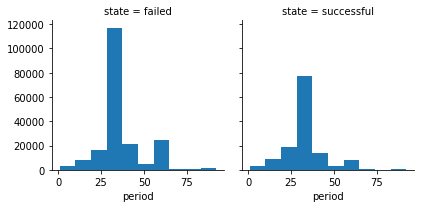

In [11]:
# 募集期間による成否の変化
g = sns.FacetGrid(df, col='state')
g.map(plt.hist, 'period', bins=10)

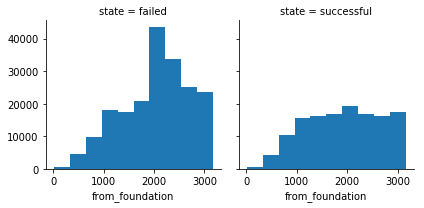

In [12]:
# Kickstarter設立からの日数による成否の変化
g = sns.FacetGrid(df, col='state')
g.map(plt.hist, 'from_foundation', bins=10)

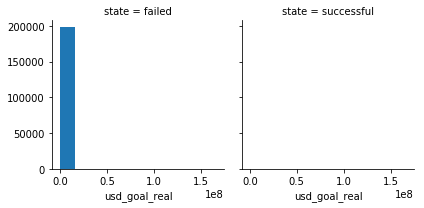

In [19]:
# ファンディングゴールによる成否の変化
g = sns.FacetGrid(df, col='state')
g.map(plt.hist, 'usd_goal_real', bins=10)

まともにグラフが描けない…↑で見たようにusd_goal_realの最大値は1e8のオーダーなので、  
そのデータに引っ張られて詳細なデータが描けていない。

In [58]:
for i in (1e4,1e5,1e6,1e7,1e8):
    print("ゴールが{:.1e}USD以上のデータ数={}".format(i, len(df.query("usd_goal_real >= @i"))))

ゴールが1.0e+04USD以上のデータ数=122881
ゴールが1.0e+05USD以上のデータ数=12540
ゴールが1.0e+06USD以上のデータ数=1072
ゴールが1.0e+07USD以上のデータ数=146
ゴールが1.0e+08USD以上のデータ数=24


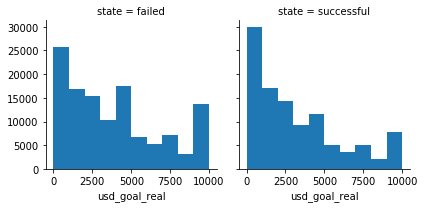

In [63]:
# ゴールが1e4以下のデータでグラフを再描画
df_tmp = df.query("usd_goal_real <= 1e4")
g = sns.FacetGrid(df_tmp, col='state')
g.map(plt.hist, 'usd_goal_real', bins=10)

### 可視化をした上での所感 
・募集期間はキリがいい30日が多い。以前は90日まで設定可能だったらしいが、短い方が成功しやすいということで現在では60日までしか設定できない。  
実際に30日以内の方が成功率が高いように見える。  
https://www.kickstarter.com/blog/shortening-the-maximum-project-length  
・設立6年目くらいが爆発的にプロジェクトの数が多く、成功率が低い。その他の期間は軒並み一定の成功率か。   
6年目を起点にした日数を特徴量にしても良いが、線形回帰では少々難しいか。  
・ファンディングゴールは切りの良い金額のプロジェクトが多い。やはり目標が低いほど成功率が高い傾向がある。  

→期間と目標だけを説明変数として学習をしてみる

In [162]:
X = df[["usd_goal_real","period"]].values
y = df["state"].values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol = None)
clf.fit(X, y)

/Users/tsubasa/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [163]:
y_est = clf.predict(X)
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

正答率 = 61.393%


In [168]:
# 混同行列と各種評価指標
conf_mat = pd.DataFrame(confusion_matrix(y, y_est,labels=["successful","failed"]), 
                        index=['正解 = successful', '正解 = failed'], 
                        columns=['予測 = successful', '予測 = failed'])
display(conf_mat)

precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est,labels=["successful","failed"])
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

,予測 = successful,予測 = failed
正解 = successful,33124,100832
正解 = failed,27219,170500


適合率（Precision） = 54.893%
再現率（Recall） = 24.728%
F1値（F1-score） = 34.096%


Recallがすこぶる悪い。何らかの原因で失敗予測をする方にモデルが偏っている様子。

In [154]:
# 重み表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0,0]
w2 = clf.coef_[0,1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))

w0 = 2942.859, w1 = -1.092, w2 = -55.794


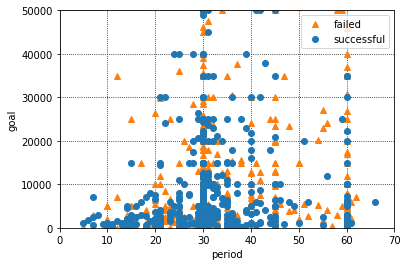

In [68]:
# 目標と期間を軸にして成否をプロット
plt.grid(which='major',color='black',linestyle=':')

df_tmp = df.query("state == 'failed'"). sample(500)
x1 = df_tmp["period"]
x2 = df_tmp["usd_goal_real"]
plt.plot(x1, x2, '^', color='C1', label='failed')

df_tmp = df.query("state == 'successful'"). sample(500)
x1 = df_tmp["period"]
x2 = df_tmp["usd_goal_real"]
plt.plot(x1, x2, 'o', color='C0', label='successful')


plt.xlim([0,70])
plt.ylim([0,5e4])
plt.legend(loc='best')

plt.xlabel("period")
plt.ylabel("goal")
plt.show()

目標と期間だけではとてもじゃないが分類し切れるとは思えない…

### カテゴリーの影響調査

In [78]:
# 扱いやすいように成功=1,失敗=0とする
df["state"] = df["state"].replace("successful",1).replace("failed",0)

In [90]:
# main_category毎の成功確率
df_tmp = df[["main_category", "state"]].groupby(['main_category'], as_index=False).mean().sort_values(by='state', ascending=False)
df_tmp["count"] = df[["main_category", "state"]].groupby(['main_category'], as_index=False).count()["state"]
df_tmp

,main_category,state,count
3,Dance,0.654352,3573
14,Theater,0.637961,10242
1,Comics,0.591415,9878
10,Music,0.526606,45949
0,Art,0.448890,25641
8,Games,0.438905,28521
6,Film & Video,0.417906,56527
4,Design,0.415944,25364
12,Publishing,0.347017,35445
11,Photography,0.341108,9689


In [102]:
# category毎の成功確率
df_tmp = df[["category", "state"]].groupby(['category'], as_index=False).mean().sort_values(by='state', ascending=False)
df_tmp["count"] = df[["category", "state"]].groupby(['category'], as_index=False).count()["state"]
display(df_tmp.head())
display(df_tmp.tail())

,category,state,count
21,Chiptune,0.818182,33
122,Residencies,0.735294,68
6,Anthologies,0.706920,737
36,Dance,0.695221,2218
83,Literary Spaces,0.684211,19


,category,state,count
59,Food Trucks,0.137865,1574
146,Video,0.132468,385
88,Mobile Games,0.106029,1443
151,Web,0.102808,4309
8,Apps,0.071496,5287


カテゴリーによる成功率の違いは歴然。絶対にモデルに組み込むべき。  
ただ数値データではないので線形モデルには組み込みにくいか。one-hot形式にしてみるか。

In [117]:
df2 = df.drop(["name","category","deadline","launched","from_foundation"],axis =1)
for i in df2["main_category"].unique():
    df2[i] = 0
    df2.loc[df['main_category'] == i, i] = 1
df2.head()

,main_category,state,usd_goal_real,period,Publishing,Film & Video,Music,Food,Crafts,Games,Design,Comics,Fashion,Theater,Art,Photography,Technology,Dance,Journalism
0,Publishing,0,1533.95,59.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Film & Video,0,30000.00,60.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Film & Video,0,45000.00,45.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Music,0,5000.00,30.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,Food,1,50000.00,35.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [124]:
# カテゴリー情報を加えて再学習
X = df2.drop(["main_category","state"],axis=1).values
y = df2["state"].values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol = None)
clf.fit(X, y)

/Users/tsubasa/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [125]:
y_est = clf.predict(X)
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

正答率 = 62.537%


あまり変わらない。特徴抽出が悪いのか、ロジスティック回帰の限界なのか…

# day2

 to do
- <a href = "#前処理">前処理(標準化、無相関化など)</a>
- <a href ="#サポートベクターマシンによる分類">サポートベクターマシンで分類</a>
- <a href="#回帰手法で分類">回帰手法を使って分類</a>
- <a href= "#中間まとめ">まとめ</a>

# 前処理

### 外れ値の確認 
- 1970年にlaunchされたプロジェクトはcanceledかsuspendedなので放って置く

In [2]:
df = pd.read_csv("raw_data/ks-projects-201801.csv")
df.sort_values('launched').head(10)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
75397,1384087152,"""ICHOR"" (Canceled)",Film & Video,Film & Video,USD,2010-05-21,700.0,1970-01-01 01:00:00,0.0,canceled,0,US,0.0,0.0,700.00
319002,69489148,Student Auditions Music 2015,Publishing,Publishing,CHF,2015-10-31,1900.0,1970-01-01 01:00:00,0.0,suspended,0,CH,0.0,0.0,1905.97
2842,1014746686,Salt of the Earth: A Dead Sea Movie (Canceled),Film & Video,Film & Video,USD,2010-09-15,5000.0,1970-01-01 01:00:00,0.0,canceled,0,US,0.0,0.0,5000.00
94579,1480763647,"Support Solo Theater! Help ""Ungrateful Daughte...",Theater,Theater,USD,2010-06-01,4000.0,1970-01-01 01:00:00,0.0,canceled,0,US,0.0,0.0,4000.00
247913,330942060,"Help RIZ Make A Charity Album: 8 Songs, 8 Caus...",Music,Music,USD,2010-05-04,10000.0,1970-01-01 01:00:00,0.0,canceled,0,US,0.0,0.0,10000.00
273779,462917959,Identity Communications Infographic (Canceled),Design,Design,USD,2010-04-10,500.0,1970-01-01 01:00:00,0.0,canceled,0,US,0.0,0.0,500.00
48147,1245461087,1st Super-Size Painting - Social Network Owned...,Art,Art,USD,2010-08-14,15000.0,1970-01-01 01:00:00,0.0,canceled,0,US,0.0,0.0,15000.00
169268,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,USD,2009-05-31,1000.0,2009-04-21 21:02:48,625.0,failed,30,US,625.0,625.0,1000.00
322000,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Shorts,Film & Video,USD,2009-07-20,80000.0,2009-04-23 00:07:53,22.0,failed,3,US,22.0,22.0,80000.00
138572,1703704063,drawing for dollars,Illustration,Art,USD,2009-05-03,20.0,2009-04-24 21:52:03,35.0,successful,3,US,35.0,35.0,20.00


In [8]:
# day1宿題と同様にデータ加工
df = pd.read_csv("raw_data/ks-projects-201801.csv")
df = df.query("state == 'successful' or state =='failed'") # 成功と失敗のデータだけを抜き出す
df["from_foundation"] = (pd.to_datetime(df["deadline"])-dt(2009,4,28)).astype('timedelta64[D]') # 設立日からの日数を計算
df["period"] = (pd.to_datetime(df["deadline"])-pd.to_datetime(df["launched"])).astype('timedelta64[D]')+1 # 募集期間を計算
df["state"] = df["state"].replace("successful",1).replace("failed",0) # 成功=1,失敗=0とする
df = df.drop(["ID","currency","pledged","goal","backers","usd pledged","usd_pledged_real","country","deadline","launched"],axis=1) # 不要なデータを落とす
df = df.reset_index() # indexをつけ直す
print(len(df))
display(df.head())
display(df.describe(include='all'))

331675


,index,name,category,main_category,state,usd_goal_real,from_foundation,period
0,0,The Songs of Adelaide & Abullah,Poetry,Publishing,0,1533.95,2355.0,59.0
1,1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,0,30000.00,3109.0,60.0
2,2,Where is Hank?,Narrative Film,Film & Video,0,45000.00,1400.0,45.0
3,3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,0,5000.00,1084.0,30.0
4,5,Monarch Espresso Bar,Restaurants,Food,1,50000.00,2530.0,35.0


,index,name,category,main_category,state,usd_goal_real,from_foundation,period
count,331675.000000,331672,331675,331675,331675.000000,3.316750e+05,331675.000000,331675.000000
unique,NaN,329594,159,15,NaN,NaN,NaN,NaN
top,NaN,New EP/Music Development,Product Design,Film & Video,NaN,NaN,NaN,NaN
freq,NaN,15,18680,56527,NaN,NaN,NaN,NaN
mean,189273.481532,NaN,NaN,NaN,0.403877,4.151000e+04,1986.979718,33.954902
std,109321.849628,NaN,NaN,NaN,0.490674,1.108930e+06,701.200100,12.713329
min,0.000000,NaN,NaN,NaN,0.000000,1.000000e-02,5.000000,1.000000
25%,94532.500000,NaN,NaN,NaN,0.000000,2.000000e+03,1464.000000,30.000000
50%,189369.000000,NaN,NaN,NaN,0.000000,5.000000e+03,2051.000000,30.000000
75%,283890.500000,NaN,NaN,NaN,1.000000,1.500000e+04,2538.000000,36.000000


↑usd_goal_realの75%が1e4$のオーダーだが、最大で1e8のデータがあるのが気になる。標準化でなんとかなるか？

### 欠損値の確認 
- nameが無いデータが存在。ごく少数(3データ)なので切ってしまう

In [4]:
print(print(df.isnull().sum()))
df = df.dropna()
print(len(df))

index              0
name               3
category           0
main_category      0
state              0
usd_goal_real      0
from_foundation    0
period             0
dtype: int64
None
331672


### nameの取扱
- わかりやすい名前の方が投資家に受けやすい？→文字数・単語数による成功率を見てみる
- 本当はセマンティック分析みたいなことをしたいが、難しいので後回し

In [6]:
df["letters"] = df["name"].apply(lambda x: len(str(x).replace(' ', '')))
df["words"] = df["name"].apply(lambda x: len(x.split()))
df["LetterBand"] = pd.cut(df['letters'], 5)
df["WordBand"] = pd.cut(df['words'], 5)

In [7]:
df.groupby(["LetterBand"], as_index=False).mean().sort_values(by='state', ascending=False)[["LetterBand","state"]]
#df.groupby(["LetterBand"], as_index=False).count()[["LetterBand","state"]]

,LetterBand,state
4,"(61.0, 76.0]",0.467597
2,"(31.0, 46.0]",0.452496
3,"(46.0, 61.0]",0.451497
1,"(16.0, 31.0]",0.393008
0,"(0.925, 16.0]",0.320112


In [8]:
df.groupby(["WordBand"], as_index=False).mean().sort_values(by='state', ascending=False)[["WordBand","state"]]
#df.groupby(["WordBand"], as_index=False).count()

,WordBand,state
4,"(23.4, 29.0]",0.500000
1,"(6.6, 12.2]",0.462211
2,"(12.2, 17.8]",0.456665
0,"(0.972, 6.6]",0.368541
3,"(17.8, 23.4]",0.368421


微妙だが一応名前が短すぎると成功率は下がる傾向がある。長過ぎる名前はデータ数が少ないけど成功率は高め。

### 無相関化 
対した相関なさそうだが取り敢えずやっとく

In [9]:
params = ["usd_goal_real","from_foundation","period"]
display(df[params].corr())
cov = np.cov(df[params], rowvar=0) # 分散・共分散を求める
_, S = np.linalg.eig(cov)           # 分散共分散行列の固有ベクトルを用いて
df_decorr = np.dot(S.T, df[params].T).T #データを無相関化
display(pd.DataFrame(df_decorr,columns=params).corr())

,usd_goal_real,from_foundation,period
usd_goal_real,1.000000,0.012949,0.021607
from_foundation,0.012949,1.000000,-0.156558
period,0.021607,-0.156558,1.000000


,usd_goal_real,from_foundation,period
usd_goal_real,1.000000e+00,5.849019e-18,-5.784660e-17
from_foundation,5.849019e-18,1.000000e+00,6.657491e-16
period,-5.784660e-17,6.657491e-16,1.000000e+00


### 標準化

In [10]:
stdsc = StandardScaler()
stdsc.fit(df_decorr)
df_white  = pd.DataFrame(stdsc.transform(df_decorr),columns=params)
display(df_white.describe()) # 一応stdが0になっていることを確認

,usd_goal_real,from_foundation,period
count,3.316750e+05,3.316750e+05,3.316750e+05
mean,2.814868e-17,-9.107601e-16,2.377285e-16
std,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.499826e+02,-2.826186e+00,-4.841714e+00
25%,2.390597e-02,-7.454869e-01,-4.497976e-01
50%,3.292368e-02,9.038084e-02,-2.365928e-01
75%,3.562901e-02,7.849482e-01,2.202607e-01
max,3.743255e-02,1.689253e+00,4.559152e+00


In [11]:
# 白色化した結果を新しいdf2に反映
df2 = df
df2 = df2.drop("index",axis=1)
for n in params:
    df2[n] = df_white[n]
df2 = df2.dropna()
df2.head()

,name,category,main_category,state,usd_goal_real,from_foundation,period
0,The Songs of Adelaide & Abullah,Poetry,Publishing,0,0.036049,0.525249,2.079428
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,0,0.010379,1.600295,2.329361
2,Where is Hank?,Narrative Film,Film & Video,0,-0.003147,-0.837258,0.746774
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,0,0.032924,-1.287420,-0.518919
4,Monarch Espresso Bar,Restaurants,Food,1,-0.007656,0.774372,0.206141


### サポートベクターマシンによる分類

In [32]:
test_size = 0.2
X = df2[["usd_goal_real", "period"]].values
y = df2["state"].values
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size=test_size, random_state=1234)

In [13]:
# 手始めに適当なパラメータで訓練
C = 5
kernel = "rbf"
gamma = 1
clf = SVC(C=C, kernel=kernel, gamma=gamma,verbose=True)
clf.fit(X_train, y_train)

[LibSVM]

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [14]:
print("識別精度=",clf.score(X_test, y_test))

識別精度= 0.594973919860102


適当なパラメータであるが、識別制度は0.59。学習に１時間以上かかる割にイマイチな結果。このままでクロスバリデーションをやるのは厳しい。訓練データを減らした方が良いかもしれない。

In [21]:
# カテゴリ変数も加えてSVM
for i in df2["main_category"].unique():
    df2[i] = 0
    df2.loc[df['main_category'] == i, i] = 1
df2.head()

,name,category,main_category,state,usd_pledged_real,usd_goal_real,from_foundation,period,goal_white,period_white,...,Games,Design,Comics,Fashion,Theater,Art,Photography,Technology,Dance,Journalism
0,The Songs of Adelaide & Abullah,Poetry,Publishing,0,0.0,1533.95,2355.0,59.0,-0.036049,1.971229,...,0,0,0,0,0,0,0,0,0,0
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,0,2421.0,30000.00,3109.0,60.0,-0.010379,2.049351,...,0,0,0,0,0,0,0,0,0,0
2,Where is Hank?,Narrative Film,Film & Video,0,220.0,45000.00,1400.0,45.0,0.003147,0.868917,...,0,0,0,0,0,0,0,0,0,0
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,0,1.0,5000.00,1084.0,30.0,-0.032924,-0.310445,...,0,0,0,0,0,0,0,0,0,0
4,Monarch Espresso Bar,Restaurants,Food,1,52375.0,50000.00,2530.0,35.0,0.007656,0.082059,...,0,0,0,0,0,0,0,0,0,0


非線形分類ができるSVCクラスに正則化のオプションが見当たらない…そもそもデータ数を増やしたら一晩かけても学習が終わらない。  
線形だがLinearSVCで妥協する。

In [51]:
test_size = 0.3 # データ多すぎるんで訓練比率下げる
X = df2.drop(["name","category","main_category","state"],axis =1).values
y = df2["state"].values
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size=test_size, random_state=1234)

In [11]:
%%time
clf = LinearSVC(penalty='l1',dual = False)
clf.fit(X_train, y_train)

CPU times: user 161 ms, sys: 31.3 ms, total: 193 ms
Wall time: 192 ms


In [12]:
print("識別精度=",clf.score(X_test, y_test))

識別精度= 0.595049295986975


線形カーネル関数なら一瞬で学習が終わるので、これで調整してみよう。といってもC以外に調整できそうなものがなかったが。

### パラメータの最適化

In [52]:
%%time
parameters = {'C':[1e-20,1e-15,1e-10,1e-7,1e-5,1e-3,1e-1,1,10],'penalty':['l1','l2'],'dual':[False]} 
model= LinearSVC()
clf = GridSearchCV(model, parameters, cv=3)
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)

{'C': 1, 'dual': False, 'penalty': 'l1'} 0.6229153027118294
CPU times: user 37.9 s, sys: 2.82 s, total: 40.8 s
Wall time: 33.9 s


In [53]:
print("識別精度=",clf.score(X_test, y_test))

識別精度= 0.6219535482055457


In [54]:
y_est = clf.predict(X_test)

In [55]:
# 混同行列と各種評価指標
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est,labels=[1,0]), 
                        index=['正解 = successful', '正解 = failed'], 
                        columns=['予測 = successful', '予測 = failed'])
display(conf_mat)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est,labels=[1,0])
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

,予測 = successful,予測 = failed
正解 = successful,10839,29448
正解 = failed,8168,51046


適合率（Precision） = 57.026%
再現率（Recall） = 26.904%
F1値（F1-score） = 36.560%


どの条件でも対して変わらない…訓練誤差と汎化誤差が変わらないので、まだアンダーフィッティングの段階と思われる

## 回帰手法で分類 
モチベーション
- 成功した多くのケースで投資額が目標を上回っている。
- 目的変数をstateにした場合はpledgedは使えないので、上回った額の情報を切り捨てている。
- 同様に失敗したケースでも、どれくらい目標まで離れているかという情報も活用できていない。
- 目的変数をpledgedとした回帰問題を解き、予測結果が目標を上回れば成功と判断すれば分類可能
- 成功か失敗かの２値しか持たないstateよりもpledgedの方が良い教師データになるはず

In [30]:
# day1宿題と同様にデータ加工
df = pd.read_csv("raw_data/ks-projects-201801.csv")
df = df.query("state == 'successful' or state =='failed'") # 成功と失敗のデータだけを抜き出す
df["from_foundation"] = (pd.to_datetime(df["deadline"])-dt(2009,4,28)).astype('timedelta64[D]') # 設立日からの日数を計算
df["period"] = (pd.to_datetime(df["deadline"])-pd.to_datetime(df["launched"])).astype('timedelta64[D]')+1 # 募集期間を計算
df["state"] = df["state"].replace("successful",1).replace("failed",0) # 成功=1,失敗=0とする
df = df.drop(["ID","currency","pledged","goal","backers","usd pledged","country","deadline","launched"],axis=1) # 不要なデータを落とす
df = df.reset_index() # indexをつけ直す

In [31]:
params = ["usd_goal_real","period"]
cov = np.cov(df[params], rowvar=0) # 分散・共分散を求める
_, S = np.linalg.eig(cov)           # 分散共分散行列の固有ベクトルを用いて
df_decorr = np.dot(S.T, df[params].T).T #データを無相関化
stdsc = StandardScaler()
stdsc.fit(df_decorr)
df_white  = pd.DataFrame(stdsc.transform(df_decorr),columns=params)

In [32]:
# 白色化した結果を新しいdf2に反映
df2 = df
df2 = df2.drop("index",axis=1)
df2["goal_white"] = df_white["usd_goal_real"]
df2["period_white"] = df_white["period"]
df2 = df2.dropna()
df2.head()

,name,category,main_category,state,usd_pledged_real,usd_goal_real,from_foundation,period,goal_white,period_white
0,The Songs of Adelaide & Abullah,Poetry,Publishing,0,0.0,1533.95,2355.0,59.0,-0.036049,1.971229
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,0,2421.0,30000.00,3109.0,60.0,-0.010379,2.049351
2,Where is Hank?,Narrative Film,Film & Video,0,220.0,45000.00,1400.0,45.0,0.003147,0.868917
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,0,1.0,5000.00,1084.0,30.0,-0.032924,-0.310445
4,Monarch Espresso Bar,Restaurants,Food,1,52375.0,50000.00,2530.0,35.0,0.007656,0.082059


In [40]:
# データをテスト用と訓練用でわける
test_size = 0.2
df_train, df_test =  train_test_split(df2,test_size=test_size, random_state=1234)
X_train = df_train[["goal_white","period_white"]].values
y_train = df_train["usd_pledged_real"].values
X_test = df_test[["goal_white","period_white"]].values
y_test = df_test["usd_pledged_real"].values

#### ひとまずRidge正則化付きで5次元多項式で回帰してみる

In [6]:
%%time
degree = 5
alpha = 1e-4
est = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
est.fit(X_train, y_train)

CPU times: user 259 ms, sys: 71.3 ms, total: 331 ms
Wall time: 320 ms


/Users/tsubasa/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.225788e-26
  overwrite_a=True).T


In [29]:
y_est = est.predict(X_test)
df_p = pd.DataFrame(y_est,columns=["est_pledge"])
df_p["real_goal"] = df_test["usd_goal_real"].values
df_p["real_state"] = df_test["state"].values
df_p["est_state"] = 1
df_p["est_state"] = df_p["est_state"].where(df_p["est_pledge"]>df_p["real_goal"],0)
print('正答率 = {:.3f}%'.format(100 * accuracy_score(df_p["real_state"], df_p["est_state"])))
df_p.head()

正答率 = 56.640%


,est_pledge,real_goal,real_state,est_state
0,49528.570466,550097.37,1,0
1,2573.195238,5000.00,0,0
2,3336.762493,2500.00,1,1
3,9054.618566,1880.00,0,1
4,8954.854459,500.00,1,1


正答率は微妙だが、L2正則化なら訓練が一瞬で終わるのは魅力的。色々な条件で試しやすい。

### パラメータ最適化

In [41]:
%%time
parameters = {'polynomialfeatures__degree':[1,3,5,7,9], 'ridge__alpha':[0,1e-6,1e-4,1e-2,1e-1]} 
model= make_pipeline(PolynomialFeatures(),Ridge())
clf = GridSearchCV(model, parameters, cv=3)
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)

{'polynomialfeatures__degree': 1, 'ridge__alpha': 0.1} 7.117953284605639e-05
CPU times: user 1min 11s, sys: 14.6 s, total: 1min 25s
Wall time: 1min


In [42]:
y_est = clf.predict(X_test)
df_p = pd.DataFrame(y_est,columns=["est_pledge"])
df_p["real_goal"] = df_test["usd_goal_real"].values
df_p["real_state"] = df_test["state"].values
df_p["est_state"] = 1
df_p["est_state"] = df_p["est_state"].where(df_p["est_pledge"]>df_p["real_goal"],0)
print('正答率 = {:.3f}%'.format(100 * accuracy_score(df_p["real_state"], df_p["est_state"])))
df_p.head()

正答率 = 55.779%


,est_pledge,real_goal,real_state,est_state
0,10184.199693,550097.37,1,0
1,8439.885182,5000.00,0,1
2,9024.012027,2500.00,1,1
3,9667.648714,1880.00,0,1
4,9666.937880,500.00,1,1


In [44]:
# 混同行列と各種評価指標
conf_mat = pd.DataFrame(confusion_matrix(df_p["real_state"], df_p["est_state"],labels=[1,0]), 
                        index=['正解 = successful', '正解 = failed'], 
                        columns=['予測 = successful', '予測 = failed'])
display(conf_mat)

precision, recall, f1_score, _ = precision_recall_fscore_support(df_p["real_state"], df_p["est_state"],labels=[1,0])
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

,予測 = successful,予測 = failed
正解 = successful,20117,6669
正解 = failed,22665,16884


適合率（Precision） = 47.022%
再現率（Recall） = 75.103%
F1値（F1-score） = 57.834%


ロジスティック回帰やSVCでは失敗寄りに予測しているが、回帰で解いたら成功寄りの楽観的な予測になっているので、正答率は低いが各種評価指標は良く見える。

### 中間まとめ 
・ロジスティック回帰・・・max_iterの設定次第だが、時間はそれなりにかかる。特徴量が多くても一応学習は終わる。  
・非線形SVM・・・非線形だがとにかく時間がかかる。特徴量が多いと学習は終わらない。  
・線形SVM・・・特徴量が多くても一瞬で学習が終わる。  
・多項式の線形回帰・・・特徴量が少なければ一瞬だが、特徴量と次元を増やすと学習は終わらない。  
学習の速さ:線形SVM,線形回帰>ロジスティック回帰(SGD)>ガウスカーネルSVM>多項式回帰  
まだカテゴリ情報を使って非線形回帰が出来ていない。今後の戦略としては以下の3つが考えられる。    
1. 訓練データ量を思いっきり削る。３３万個あるので、1割でも十分ではないか。
2. 非線形のアルゴリズムでも学習できるようにカテゴリ情報をうまく圧縮する    
3. 大量の特徴量に対しても現実的な時間で学習できる非線形アルゴリズムを使う

#### 訓練データを1割にしてカテゴリ有りで非線形SVM

In [10]:
test_size = 0.9 # データ多すぎるんで訓練比率下げる
X = df2.drop(["name","category","main_category","state"],axis =1).values
y = df2["state"].values
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size=test_size, random_state=1234)

In [11]:
%%time
C = 5
kernel = "rbf"
gamma = 1
clf = SVC(C=C, kernel=kernel, gamma=gamma)
clf.fit(X_train, y_train)

CPU times: user 3min 7s, sys: 2.56 s, total: 3min 10s
Wall time: 3min 39s


In [12]:
print("識別精度=",clf.score(X_test, y_test))

識別精度= 0.6209987839318197


精度は維持して現実的な時間で学習は終わる。これでグリッドサーチをしてみる。

In [14]:
%%time
parameters = {'C':[1e-1,1,10],'gamma':[1e-1,1,10]} 
model= SVC(kernel="rbf")
clf = GridSearchCV(model, parameters, cv=3)
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)

{'C': 0.1, 'gamma': 1} 0.626334197672315
CPU times: user 34min 59s, sys: 23.5 s, total: 35min 23s
Wall time: 37min 16s


In [15]:
print("識別精度=",clf.score(X_test, y_test))

識別精度= 0.6223287538148695


あまり変わらない…今の特徴量とSVMではこれくらいが限界なのか？   
多項式回帰も試したが半日かかっても終わらなかった

#### ビニングで特徴量を整理 
実数の特徴量を区分けしてカテゴリ変数化すれば線形手法でも疑似的に非線形分類ができると期待

In [ ]:
df = pd.read_csv("raw_data/ks-projects-201801.csv")
df = df.query("state == 'successful' or state =='failed'") # 成功と失敗のデータだけを抜き出す
df["from_foundation"] = (pd.to_datetime(df["deadline"])-dt(2009,4,28)).astype('timedelta64[D]') # 設立日からの日数を計算
df["period"] = (pd.to_datetime(df["deadline"])-pd.to_datetime(df["launched"])).astype('timedelta64[D]')+1 # 募集期間を計算
df["state"] = df["state"].replace("successful",1).replace("failed",0) # 成功=1,失敗=0とする
df = df.drop(["ID","currency","pledged","goal","backers","usd pledged","country","deadline","launched"],axis=1) # 不要なデータを落とす
df = df.reset_index() # indexをつけ直す

In [ ]:
# カテゴリ変数を追加
for i in df["main_category"].unique():
    df[i] = 0
    df.loc[df['main_category'] == i, i] = 1

for i in df["category"].unique():
    df[i] = 0
    df.loc[df['category'] == i, i] = 1

In [2]:
# 加工に時間がかかるのでcsvに保存しとく
#　df.to_csv("ks_project2.csv")
df = pd.read_csv("ks_project2.csv")

In [3]:
# 実数の特徴量をビニング処理
df["GoalBand"] = pd.cut(df['usd_goal_real'], [0, 2500, 5000, 1e4,1e5,1e10])
df["PeriodBand"] = pd.cut(df['period'], [0,20,30,40,60,100])

In [26]:
df.groupby(["GoalBand"], as_index=False).mean().sort_values(by='state', ascending=False)[["GoalBand","state"]]
#df.groupby(["GoalBand"], as_index=False).count()[["GoalBand","state"]]

,GoalBand,state
0,"(0.0, 2500.0]",0.519434
1,"(2500.0, 5000.0]",0.441953
2,"(5000.0, 10000.0]",0.394641
3,"(10000.0, 100000.0]",0.291198
4,"(100000.0, 10000000000.0]",0.075338


In [37]:
df.groupby(["PeriodBand"], as_index=False).mean().sort_values(by='state', ascending=False)[["PeriodBand","state"]]
#df.groupby(["PeriodBand"], as_index=False).count()[["PeriodBand","state"]]

,PeriodBand,state
0,"(0, 20]",0.510236
2,"(30, 40]",0.501179
4,"(60, 90]",0.396053
1,"(20, 30]",0.392744
3,"(40, 60]",0.306886


In [4]:
# バンドをカテゴリ変数として追加
for i in df["GoalBand"].unique():
    col = "Goal"+str(i)
    df[col] = 0
    df.loc[df['GoalBand'] == i, col] = 1
    
for i in df["PeriodBand"].unique():
    col = "Period"+str(i)
    df[col] = 0
    df.loc[df['PeriodBand'] == i, col] = 1

In [ ]:
df2 = df.drop(["Unnamed: 0","index","name","category","main_category",
               "usd_pledged_real","usd_goal_real","from_foundation","period","GoalBand","PeriodBand"],axis=1) # 不要なデータを落とす

準備できたので線形SVMで学習する

In [7]:
test_size = 0.2
X = df2.drop(["state"],axis =1).values
y = df2["state"].values
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size=test_size, random_state=1234)

In [8]:
%%time
parameters = {'C':[1e-20,1e-15,1e-10,1e-7,1e-5,1e-3,1e-1,1,10],'penalty':['l1','l2'],'dual':[False]} 
model= LinearSVC()
clf = GridSearchCV(model, parameters, cv=3)
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)

{'C': 1, 'dual': False, 'penalty': 'l1'} 0.6708034973995628
CPU times: user 1min 48s, sys: 28.9 s, total: 2min 17s
Wall time: 2min 17s


In [9]:
print("識別精度=",clf.score(X_test, y_test))

識別精度= 0.6702193412225823


今までで最高記録！ビニングの効果というよりカテゴリを追加したのが大きいか？  
カテゴリ＆メインカテゴリのみで学習

In [3]:
df2 = df.drop(["Unnamed: 0","index","name","category","main_category",
               "usd_pledged_real","usd_goal_real","from_foundation","period"],axis=1) # 不要なデータを落とす

In [5]:
test_size = 0.2
X = df2.drop(["state"],axis =1).values
y = df2["state"].values
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size=test_size, random_state=1234)

In [6]:
%%time
parameters = {'C':[1e-20,1e-15,1e-10,1e-7,1e-5,1e-3,1e-1,1,10],'penalty':['l1','l2'],'dual':[False]} 
model= LinearSVC()
clf = GridSearchCV(model, parameters, cv=3)
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)

{'C': 0.1, 'dual': False, 'penalty': 'l1'} 0.6509421873822265
CPU times: user 1min 10s, sys: 26.5 s, total: 1min 36s
Wall time: 1min 26s


In [7]:
print("識別精度=",clf.score(X_test, y_test))

識別精度= 0.652008743498907


カテゴリ＆メインカテゴリ＋白色化した目標・期間

In [33]:
# カテゴリ変数を追加
for i in df2["main_category"].unique():
    df2[i] = 0
    df2.loc[df2['main_category'] == i, i] = 1

for i in df2["category"].unique():
    df2[i] = 0
    df2.loc[df2['category'] == i, i] = 1

In [35]:
df2 = df2.drop(["usd_pledged_real","usd_goal_real","period","name","category","main_category","from_foundation"],axis=1) # 不要なデータを落とす

In [36]:
test_size = 0.2
X = df2.drop(["state"],axis =1).values
y = df2["state"].values
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size=test_size, random_state=1234)

In [37]:
%%time
parameters = {'C':[1e-20,1e-15,1e-10,1e-7,1e-5,1e-3,1e-1,1,10],'penalty':['l1','l2'],'dual':[False]} 
model= LinearSVC()
clf = GridSearchCV(model, parameters, cv=3)
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)

{'C': 10, 'dual': False, 'penalty': 'l1'} 0.6640800189947124
CPU times: user 1min 21s, sys: 11.4 s, total: 1min 33s
Wall time: 1min 31s


In [38]:
print("識別精度=",clf.score(X_test, y_test))

識別精度= 0.662591392176076


### day2まとめ 
・カテゴリ、メインカテゴリ、期間・目標のビニングを特徴量として、線形SVMで67%の精度  
・カテゴリ情報の貢献が大きい。期間と目標は白色化よりもビニングしたほうがわずかに有利か  
・訓練誤差と汎化誤差が変わらないので、まだアンダーフィッティングの域を脱していないと思われる 